In [23]:
#!pip install greek-stemmer'
#!pip install pyLDAvis

In [53]:
import demoji
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import PorterStemmer
from greek_stemmer import GreekStemmer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.utils import simple_preprocess
import gensim
import pickle 
import pyLDAvis
import os
import pyLDAvis.gensim_models
import numpy as np
import gensim.corpora as corpora
from pprint import pprint

# Load Dataset

In [25]:
# Read the CSV file and drop unneeded columns 
reviews = pd.read_csv('reviews.csv', encoding='utf-8')

# Dataset Preprocessing

In [26]:
# Create stemmer objects for English and Greek
english_stemmer = PorterStemmer()
#greek_stemmer = GreekStemmer()

# Remove emojis
def remove_emoji(string):
    return demoji.replace(string, '')

# Remove non-alphanumeric characters
def preprocess_text(text):    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Function to perform stemming on a single word based on its language
def stem_word(word):
    word = english_stemmer.stem(word)
        #else:
            #return greek_stemmer.stem(word)
    return word

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    # these methods are deleting different kinds of stop words and we need them all out
    texts = [[gensim.parsing.preprocessing.remove_stopwords(str(text))] for text in texts]
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]        

In [27]:
# Stop words
stop_words = set(stopwords.words("english"))

stop_words_english = set(stopwords.words('english'))
stop_words_greek = set(stopwords.words('greek'))
stop_words = stop_words_english.union(stop_words_greek)
stop_words = list(stop_words)
stop_words.extend(['from', 'subject', 're', 'edu', 'use','i', 'the', 'she', 'her', 'we']) # Add custom words to remove

reviews['Review Date'] = pd.to_datetime(reviews['Review Date'])
# Remove punctuation, stop words and emojis, apply stemming and convert to lowercase 
reviews['Review Text'] = reviews['Review Text'].map(lambda x: ' '.join([stem_word(word) for word in word_tokenize(preprocess_text(remove_emoji(x.translate(str.maketrans('', '', string.punctuation)).lower()))) if word not in stop_words]))

# Query 1

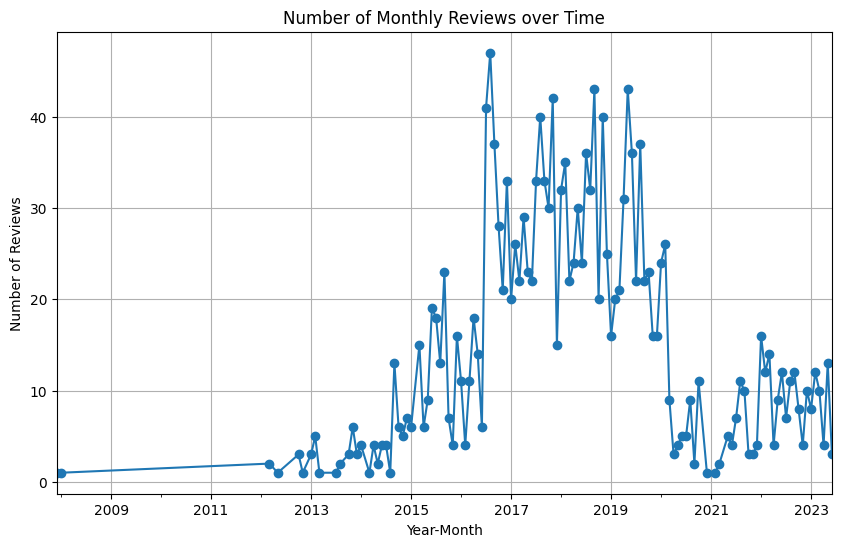

In [28]:
query1_df = reviews

#Convert review date into datetime
query1_df['Review Date'] = pd.to_datetime(query1_df['Review Date'])

#Retrieve the Month of the review date
query1_df['Year-Month'] = query1_df['Review Date'].dt.to_period('M')

#Group df by year and month
monthly_reviews = query1_df.groupby('Year-Month').size()

# Plot the monthly reviews over the years
plt.figure(figsize=(10, 6))
monthly_reviews.plot(kind='line', marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Monthly Reviews over Time')
plt.grid(True)
plt.show()

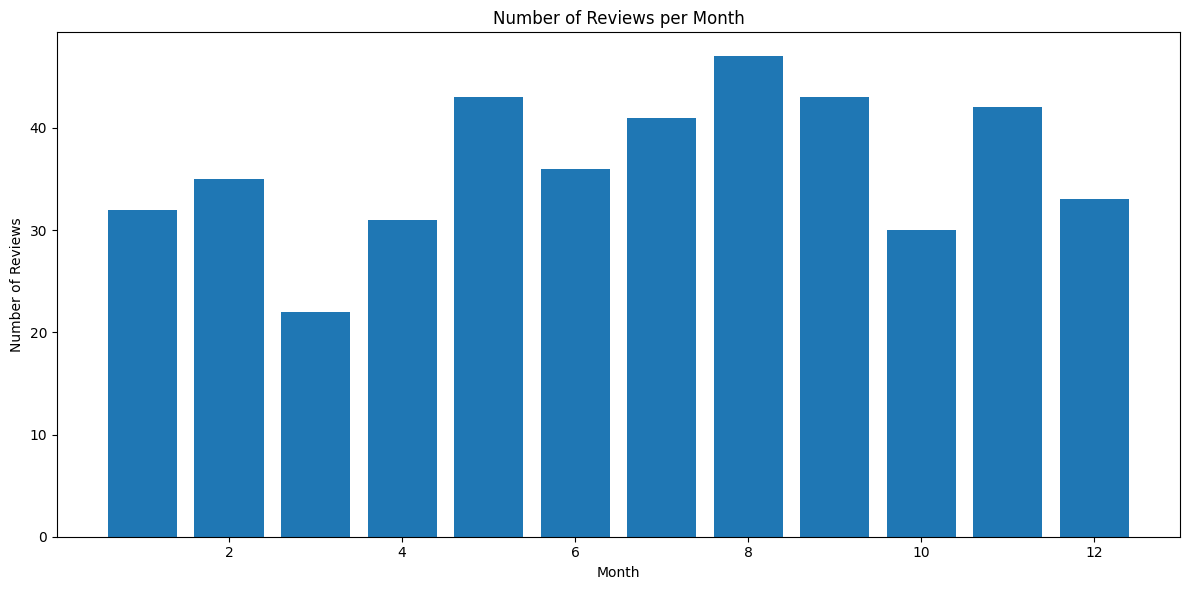

In [29]:
# Extract only Year
query1_df['Year'] = query1_df['Review Date'].dt.year
query1_df['Month'] = query1_df['Review Date'].dt.month

# Group reviews by year and month and count the number of reviews in each month
monthly_reviews = query1_df.groupby(['Year', 'Month']).count()['Review Date']

# Convert the grouped data to a DataFrame
monthly_reviews_df = monthly_reviews.reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(monthly_reviews_df['Month'], monthly_reviews_df['Review Date'])
ax.set_xlabel('Month')
ax.set_ylabel('Number of Reviews')
ax.set_title('Number of Reviews per Month')

plt.tight_layout()
plt.show()

# Query 2

In [30]:
query2_df = reviews

# Group by 'Business_name' and calculate the average rating based on sum and count
df_grouped = query2_df.groupby('Business_name').agg({'Rating': ['sum', 'count']})
df_grouped.columns = ['Sum_Rating', 'Count_Reviews']
df_grouped['Average_Rating'] = df_grouped['Sum_Rating'] / df_grouped['Count_Reviews']
df_grouped = df_grouped.reset_index()

# Sort the DataFrame by average rating and count of reviews in descending order
df_sorted = df_grouped.sort_values(by=['Count_Reviews','Average_Rating'], ascending=False)

In [31]:
# Get the top 10 rated locations
top_10 = df_sorted.head(10)

# Print the top 10 rated locations
print("Top 10 rated locations:")
print(top_10)

# Get the bottom 10 rated locations
bottom_10 = df_sorted.tail(10)

# Print the bottom 10 rated locations
print("Bottom 10 rated locations:")
print(bottom_10)

Top 10 rated locations:
             Business_name  Sum_Rating  Count_Reviews  Average_Rating
64                  Koukos       823.0            169        4.869822
0    ARC Espresso Wine Bar       515.0            113        4.557522
58         JOIN Juice Bars       413.0             88        4.693182
76                   Mikel       333.0             81        4.111111
114           The Blue Cup       332.0             71        4.676056
112              Starbucks       236.0             65        3.630769
113            Sugar Angel       278.0             63        4.412698
123             To Tourlou       279.0             61        4.573770
21         Brusco Meze Bar       237.0             53        4.471698
75          Menta Cafe Bar       238.0             51        4.666667
Bottom 10 rated locations:
                      Business_name  Sum_Rating  Count_Reviews  Average_Rating
6          Anapsyktirio Anthokomiki         4.0              1             4.0
7                    

C:\Users\30698\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Text(0.98, 0.95, 'Count of Reviews')

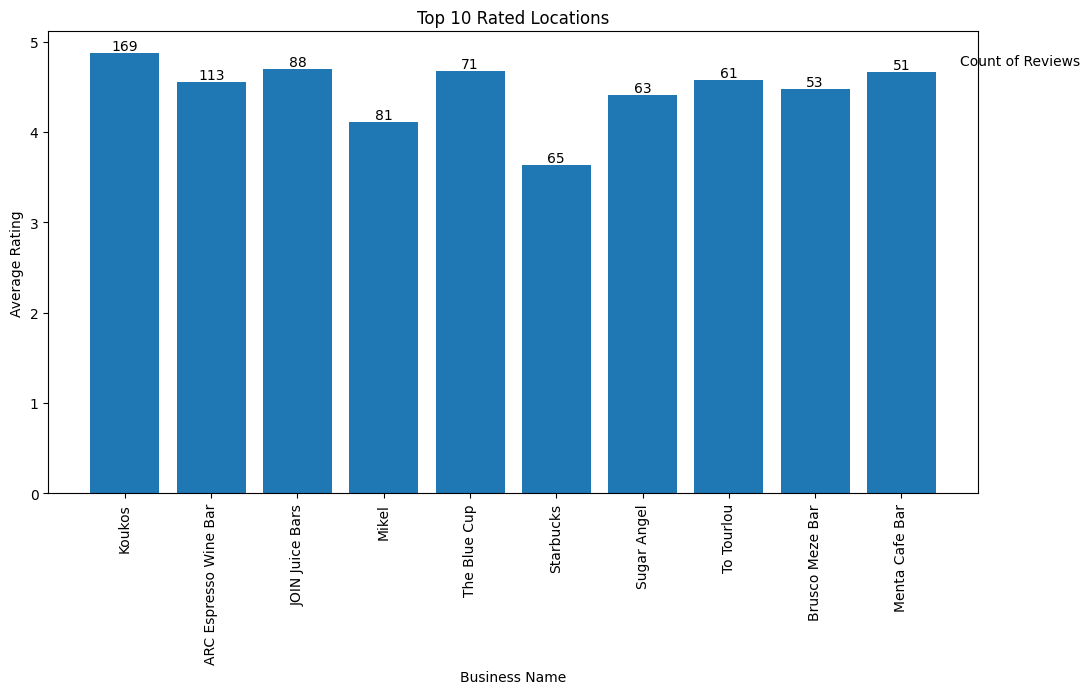

In [32]:
# Create a figure for the top 10 rated locations
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(top_10['Business_name'], top_10['Average_Rating'])
ax1.set_title('Top 10 Rated Locations')
ax1.set_xlabel('Business Name')
ax1.set_ylabel('Average Rating')
ax1.set_xticklabels(top_10['Business_name'], rotation=90)

# Add the count of reviews as text above each bar
top_counts = top_10['Count_Reviews'].tolist()
for i, bar in enumerate(ax1.patches):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), top_counts[i],ha='center', va='bottom')
ax1.text(0.98, 0.95, 'Count of Reviews', ha='left', va='top', transform=ax1.transAxes)

C:\Users\30698\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


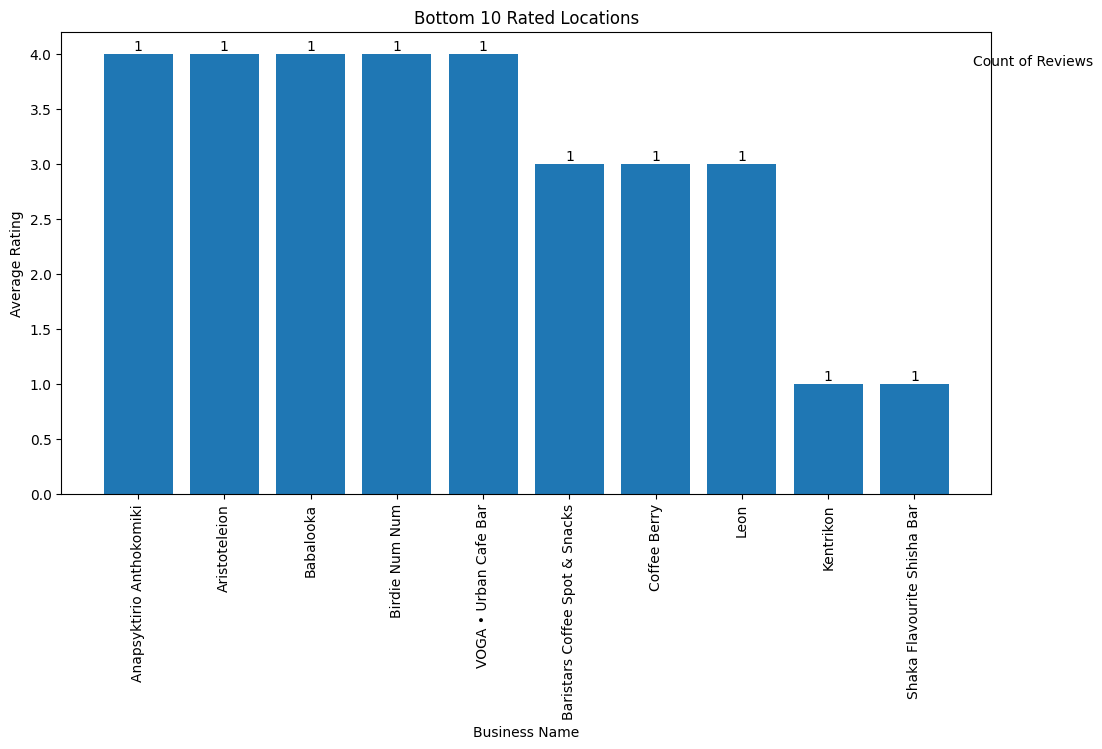

In [33]:
# Create a figure for the bottom 10 rated locations
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.bar(bottom_10['Business_name'], bottom_10['Average_Rating'])
ax2.set_title('Bottom 10 Rated Locations')
ax2.set_xlabel('Business Name')
ax2.set_ylabel('Average Rating')
ax2.set_xticklabels(bottom_10['Business_name'], rotation=90)

# Add the count of reviews as text above each bar
bottom_counts = bottom_10['Count_Reviews'].tolist()
for i, bar in enumerate(ax2.patches):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), bottom_counts[i], ha='center', va='bottom')
ax2.text(0.98, 0.95, 'Count of Reviews', ha='left', va='top', transform=ax2.transAxes)

# Display the plots
plt.show()

# Query 3

In [34]:
query3_df = reviews

# Extract only Year
query3_df['Year'] = query3_df['Review Date'].dt.year

ratings_count = query3_df.groupby(['Business_name', 'Year'])['Rating'].count().reset_index()
avg_reviews = query3_df.groupby(['Business_name', 'Year'])['Rating'].mean().reset_index()


ratings_count = ratings_count.rename(columns={'Rating': 'Ratings Count'})
avg_reviews = avg_reviews.rename(columns={'Rating': 'Average Rating'})

# Merge the dataframes based on 'Business_name' and 'Year'
combined_df = avg_reviews.merge(ratings_count, on=['Business_name', 'Year'])

# Print the combined dataframe
print(combined_df)

# Sort the combined dataframe by 'Ratings Count' in descending order
combined_df_sorted = combined_df.sort_values(by='Ratings Count', ascending=False)
combined_df_sorted

             Business_name  Year  Average Rating  Ratings Count
0    ARC Espresso Wine Bar  2015        4.200000             10
1    ARC Espresso Wine Bar  2016        4.863636             44
2    ARC Espresso Wine Bar  2017        4.250000             16
3    ARC Espresso Wine Bar  2018        4.250000             16
4    ARC Espresso Wine Bar  2019        4.923077             13
..                     ...   ...             ...            ...
442              ilios bar  2017        4.000000              1
443              ilios bar  2018        5.000000              1
444              ilios bar  2019        1.000000              1
445              ilios bar  2021        4.000000              1
446                   Ýdro  2022        5.000000              1

[447 rows x 4 columns]


,Business_name,Year,Average Rating,Ratings Count
201,Koukos,2018,4.812500,64
200,Koukos,2017,4.913043,46
1,ARC Espresso Wine Bar,2016,4.863636,44
352,Starbucks,2016,3.642857,28
202,Koukos,2019,4.962963,27
...,...,...,...,...
115,Coffee Hub,2018,4.000000,1
297,Paradosiako,2022,5.000000,1
298,Paradosiako - Mediterranean Cosmos,2015,4.000000,1
299,Paradosiako - Mediterranean Cosmos,2016,5.000000,1


In [35]:
# Keep only the rows with more that 10 reviews
filtered_df = combined_df_sorted[combined_df_sorted['Ratings Count'] > 10]


pivot_df = filtered_df.pivot(index='Business_name', columns='Year', values='Average Rating')

# Get the column names for consecutive year ranges
column_names = []
for i in range(1, len(pivot_df.columns)):
    column_names.append(f"{pivot_df.columns[i-1]}-{pivot_df.columns[i]}")

# Create a new DataFrame for percentage difference
percentage_diff_df_filter = pd.DataFrame(columns=column_names)

# Calculate the percentage difference between consecutive years
for i in range(1, len(pivot_df.columns)):
    diff = (pivot_df.iloc[:, i] - pivot_df.iloc[:, i-1]) / pivot_df.iloc[:, i-1] * 100
    diff = diff.round(2).replace(np.nan, 0)  # Round to 2 decimal points and replace NaN values with 0
    #diff = diff.apply(lambda x: f"{x}%")  # Add percentage symbol
    percentage_diff_df_filter[column_names[i-1]] = diff


percentage_diff_df_filter

,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020,2020-2022
Business_name,,,,,,
ARC Espresso Wine Bar,0.00,-12.62,0.00,15.84,0.0,0.0
Albeta Bakery,0.00,0.00,0.00,0.00,0.0,0.0
Albeta Mediterranean Bakery,0.00,0.00,0.00,0.00,0.0,0.0
Brusco Meze Bar,0.00,0.00,-2.15,2.80,0.0,0.0
Chilai Wine Restaurant Bar,0.00,-0.95,0.00,0.00,0.0,0.0
Coffee Island,0.00,0.00,1.37,0.00,0.0,0.0
JOIN Juice Bars,0.00,-1.36,-5.02,-1.98,0.0,0.0
Koukos,0.00,-1.74,-2.05,3.13,0.0,0.0
Macho Libre Cafe Bar,0.00,0.00,0.00,0.00,0.0,0.0


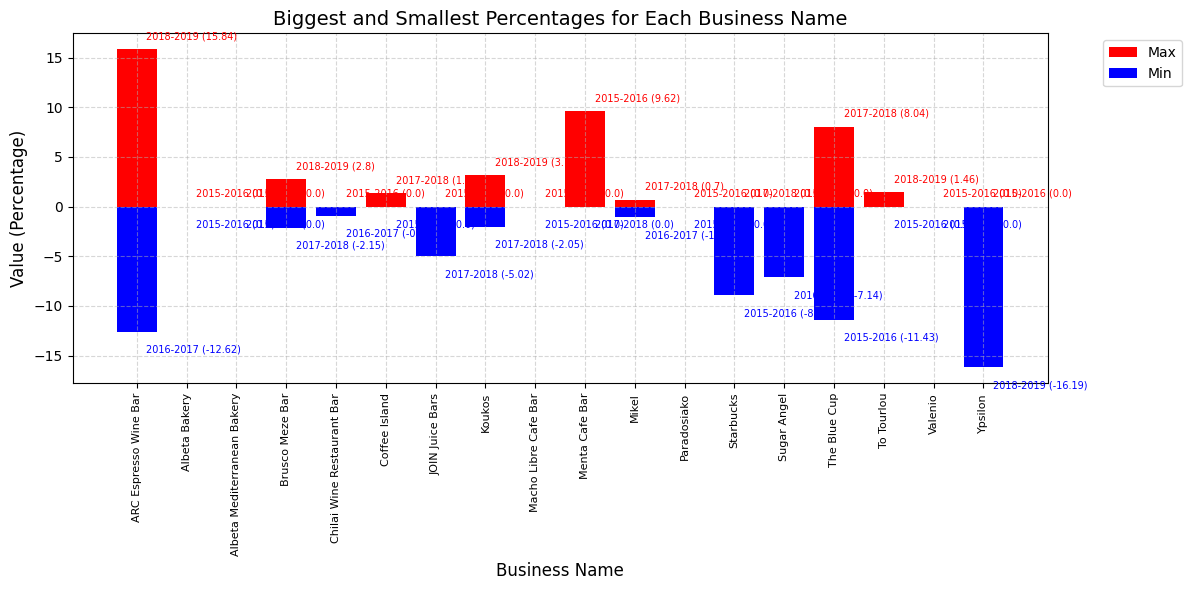

In [36]:
# Find the maximum and minimum values for each row
max_values = percentage_diff_df_filter.max(axis=1)
min_values = percentage_diff_df_filter.min(axis=1)

# Find the column names corresponding to the maximum and minimum values for each row
max_columns = percentage_diff_df_filter.idxmax(axis=1)
min_columns = percentage_diff_df_filter.idxmin(axis=1)

#Plot
fig, ax = plt.subplots(figsize=(12, 6))  
x_pos = np.arange(len(percentage_diff_df_filter))

ax.bar(
    x_pos,
    max_values,
    color='red',
    label='Max',
)
ax.bar(
    x_pos,
    min_values,
    color='blue',
    label='Min',
)


ax.set_xlabel('Business Name', fontsize=12)  
ax.set_ylabel('Value (Percentage)', fontsize=12)  
ax.set_title('Biggest and Smallest Percentages for Each Business Name', fontsize=14)  

# Add the column names near each bar
for i, shop in enumerate(percentage_diff_df_filter.index):
    ax.annotate(
        f"{max_columns[i]} ({max_values[i]})",
        xy=(x_pos[i], max_values[i]),
        xytext=(7, 7),
        textcoords='offset points',
        fontsize=7,
        color='red',
        ha='left',
    )
    ax.annotate(
        f"{min_columns[i]} ({min_values[i]})",
        xy=(x_pos[i], min_values[i]),
        xytext=(7, -15),
        textcoords='offset points',
        fontsize=7,
        color='blue',
        ha='left',
    )

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks(x_pos)
ax.set_xticklabels(percentage_diff_df_filter.index, rotation=90, fontsize=8)
ax.grid(True, linestyle='--', alpha=0.5)  # Customize gridlines with a dashed line style and reduced opacity
plt.tight_layout()


plt.show()

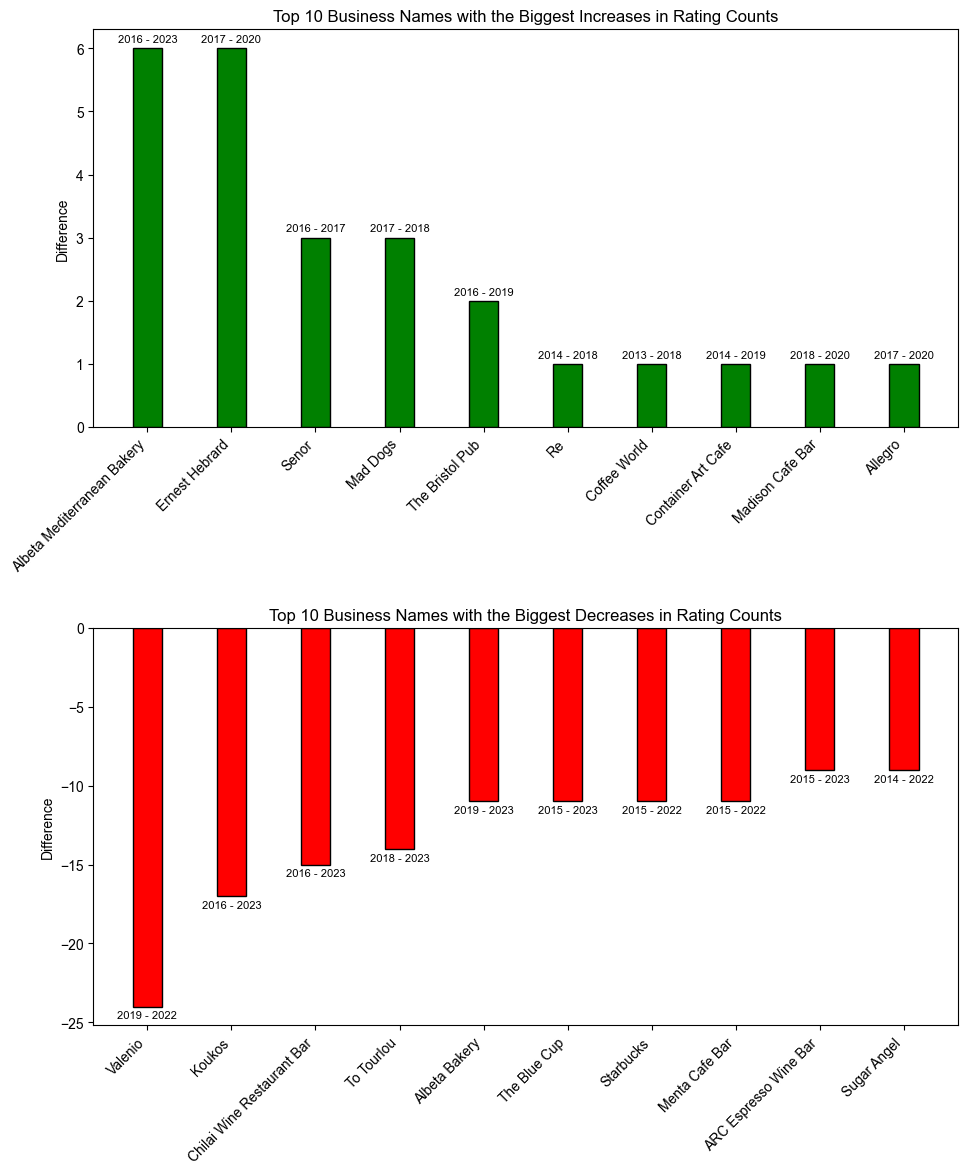

In [37]:
oldest_year = combined_df.groupby('Business_name')['Year'].min()
latest_year = combined_df.groupby('Business_name')['Year'].max()

# Calculate the rating count difference between the latest year and the oldest year
difference = combined_df.groupby('Business_name')['Ratings Count'].last() - combined_df.groupby('Business_name')['Ratings Count'].first()


result_df = pd.DataFrame({'Business_name': oldest_year.index,'Oldest Year': oldest_year.values,'Latest Year': latest_year.values,'Difference': difference.values})


result_df['Year Range'] = result_df['Oldest Year'].astype(str) + ' - ' + result_df['Latest Year'].astype(str)


# Sort the DataFrame by 'Difference' column
sorted_df = result_df.sort_values('Difference')

# Get the top 10 increases and decreases
top_increases = sorted_df.nlargest(10, 'Difference').reset_index(drop=True)
top_decreases = sorted_df.nsmallest(10, 'Difference').reset_index(drop=True)


business_names_increases = top_increases['Business_name']
business_names_decreases = top_decreases['Business_name']
year_ranges_increases = top_increases['Year Range']
year_ranges_decreases = top_decreases['Year Range']
differences_increases = top_increases['Difference']
differences_decreases = top_decreases['Difference']

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
bar_width = 0.35

x_pos_increases = np.arange(len(business_names_increases))
x_pos_decreases = np.arange(len(business_names_decreases))

ax1.bar(x_pos_increases, differences_increases, bar_width, color='green', edgecolor='black')
ax1.set_xticks(x_pos_increases)
ax1.set_xticklabels(business_names_increases, rotation=45, ha='right', fontsize=10)
ax1.set_ylabel('Difference')
ax1.set_title('Top 10 Business Names with the Biggest Increases in Rating Counts')

for i, xpos in enumerate(x_pos_increases):
    ax1.annotate(year_ranges_increases[i], xy=(xpos, differences_increases[i]), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)


ax2.bar(x_pos_decreases, differences_decreases, bar_width, color='red', edgecolor='black')
ax2.set_xticks(x_pos_decreases)
ax2.set_xticklabels(business_names_decreases, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Difference')
ax2.set_title('Top 10 Business Names with the Biggest Decreases in Rating Counts')

for i, xpos in enumerate(x_pos_decreases):
    ax2.annotate(year_ranges_decreases[i], xy=(xpos, differences_decreases[i]), xytext=(0, -10), textcoords="offset points", ha='center', va='bottom', fontsize=8)


plt.tight_layout()
plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)
plt.rcParams['axes.linewidth'] = 1.5


plt.show()

# Query 4

In [38]:
def makePlot(dict, title):
    # Generate word cloud for bigrams
    wordcloud_bigrams = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud_bigrams, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [39]:
def mostCommon1starVS5star(df, wordLength):
    five_star_reviews = df[df['Rating'] == 5]

    five_star_reviews_text = ' '.join(five_star_reviews['Review Text'])

    one_star_reviews = df[df['Rating'] == 1]

    one_star_reviews_text = ' '.join(one_star_reviews['Review Text'])

    count_vectorizer_five_star = CountVectorizer(stop_words='english', ngram_range=(wordLength, wordLength))
    word_counts_five_star = count_vectorizer_five_star.fit_transform([five_star_reviews_text])
    common_words_five_star = count_vectorizer_five_star.get_feature_names_out()
    word_counts_five_star = word_counts_five_star.toarray().squeeze()
    word_counts_df_five_star = pd.DataFrame({'Word': common_words_five_star, 'Count': word_counts_five_star})
    top_words_five_star = word_counts_df_five_star.nlargest(10, 'Count')

    count_vectorizer_one_star = CountVectorizer(stop_words='english', ngram_range=(wordLength, wordLength))
    word_counts_one_star = count_vectorizer_one_star.fit_transform([one_star_reviews_text])
    common_words_one_star = count_vectorizer_one_star.get_feature_names_out()
    word_counts_one_star = word_counts_one_star.toarray().squeeze()
    word_counts_df_one_star = pd.DataFrame({'Word': common_words_one_star, 'Count': word_counts_one_star})
    top_words_one_star = word_counts_df_one_star.nlargest(10, 'Count')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot for 5-star reviews
    ax1.bar(top_words_five_star['Word'], top_words_five_star['Count'], alpha=0.7)
    ax1.set_xlabel('Words')
    ax1.set_ylabel('Count')
    ax1.set_title('Most Common Words - 5-Star Reviews')
    ax1.set_xticklabels(top_words_five_star['Word'], rotation=45)

    # Plot for 1-star reviews
    ax2.bar(top_words_one_star['Word'], top_words_one_star['Count'], alpha=0.7)
    ax2.set_xlabel('Words')
    ax2.set_ylabel('Count')
    ax2.set_title('Most Common Words - 1-Star Reviews')
    ax2.set_xticklabels(top_words_one_star['Word'], rotation=45)

    plt.tight_layout()
    plt.show()

In [40]:
query4_df = reviews

# Most common words across all reviews
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))
word_counts = count_vectorizer.fit_transform([all_reviews_text])
common_words = count_vectorizer.get_feature_names_out()
word_counts = word_counts.toarray().squeeze()

# Word cloud for most common words across all reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Common Words Across All Reviews')
plt.show()

NameError: name 'all_reviews_text' is not defined

In [ ]:
# Retrieve bi-grams frequency
biagram_vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 2))
bigram_counts = biagram_vectorizer.fit_transform([all_reviews_text])
biagrams_words = biagram_vectorizer.get_feature_names_out()
bigram_counts = bigram_counts.toarray().squeeze()

# Create a dictionary consisting of a pair (bi-gram, frequency)
bigram_freq_dict = {}
for bigram, count in zip(biagrams_words, bigram_counts):
    bigram_text = ' '.join(bigram.split('_'))
    bigram_freq_dict[bigram_text] = count

makePlot(bigram_freq_dict, 'Bi-grams Across Reviews')

In [ ]:
# Retrieve tri-grams frequency
trigram_vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3))
trigram_counts = trigram_vectorizer.fit_transform([all_reviews_text])
trigrams_words = trigram_vectorizer.get_feature_names_out()
trigram_counts = trigram_counts.toarray().squeeze()

# Create a dictionary consisting of a pair (tri-gram, frequency)
trigram_freq_dict = {}
for trigram, count in zip(trigrams_words, trigram_counts):
    trigram_text = ' '.join(trigram.split('_'))
    trigram_freq_dict[trigram_text] = count

makePlot(trigram_freq_dict, 'Tri-grams Across Reviews')

# Query 5

### Calculate word frequencies over time

In [41]:
query5_df = reviews
query5_df = query5_df.drop(columns=['Business_name', 'Username', 'Visit Date', 'Review Title'], axis=1)

In [42]:
# Create a dictionary to store word frequencies over time
word_frequencies = defaultdict(lambda: defaultdict(int))

for _, row in query5_df.iterrows():
    text = row['Review Text']
    rating = row['Rating']
    review_date = row['Review Date']
    month = review_date.year * 100 + review_date.month  

    if text and rating and month:
        words = text.split()
        for word in words:
            word_frequencies[word][month] += 1    


### Calculate the growth rate for each word over time

In [43]:
word_growth_rates = defaultdict(list)

# Calculate the growth rate for each word over time
word_growth_rates = defaultdict(list)
for word, frequencies in word_frequencies.items():
    sorted_months = sorted(frequencies.keys())
    if len(sorted_months) > 1:
        for i in range(1, len(sorted_months)):
            year_month_diff = sorted_months[i] - sorted_months[i-1]
            growth_rate = (frequencies[sorted_months[i]] - frequencies[sorted_months[i-1]]) / year_month_diff
            word_growth_rates[word].append((sorted_months[i], growth_rate))



## Sort words based on their growth rates

In [44]:
sorted_growth_rates = sorted(word_growth_rates.items(), key=lambda x: x[1][-1][1], reverse=True)
sorted_shrink_rates = sorted(word_growth_rates.items(), key=lambda x: x[1][-1][1])

## Get the top 10 growing and shrinking words

In [45]:
top_10_growing_words = sorted_growth_rates[:10]
top_10_shrinking_words = sorted_shrink_rates[:10]

## Plotting the growth rates of the top 10 growing words

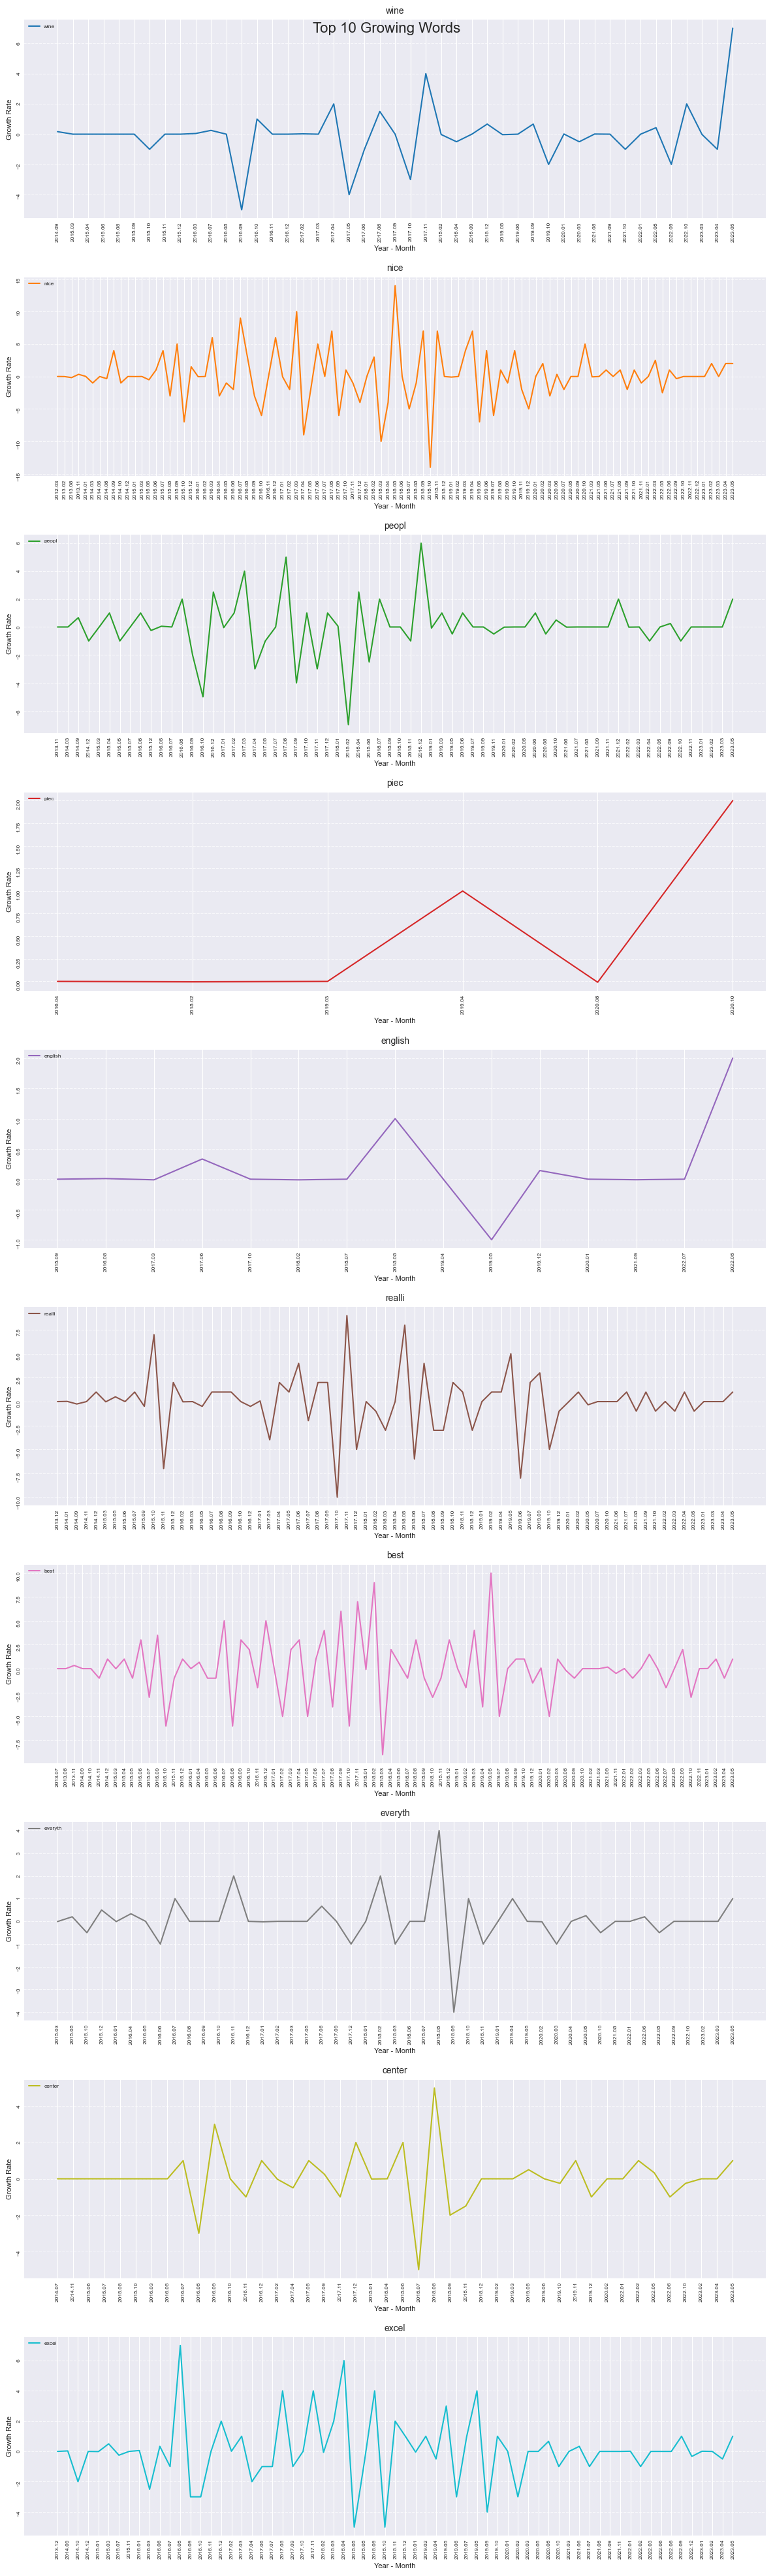

In [46]:
fig, axs = plt.subplots(10, 1, figsize=(12, 40))
fig.suptitle("Top 10 Growing Words", fontsize=16)

for i, (word, growth_rates) in enumerate(top_10_growing_words):
    ax = axs[i]  # Use the current index as the subplot index

    years, rates = zip(*growth_rates)  # Extract years and rates from growth_rates

    # Convert the key values to the desired format "YYYY.MM"
    formatted_years = [f"{str(year)[:4]}.{str(year)[4:].zfill(2)}" for year in years]

    ax.plot(formatted_years, rates, label=word, color=f"C{i}")
    ax.set_xlabel("Year - Month", fontsize=8)
    ax.set_ylabel("Growth Rate", fontsize=8)
    ax.set_title(word, fontsize=10)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.tick_params(labelsize=6, rotation=90)  # Rotate x-axis tick labels by 90 degrees
    ax.legend(fontsize=6, loc='upper left')

plt.tight_layout()
plt.show()





## Plotting the growth rates of the top 10 shrinking words

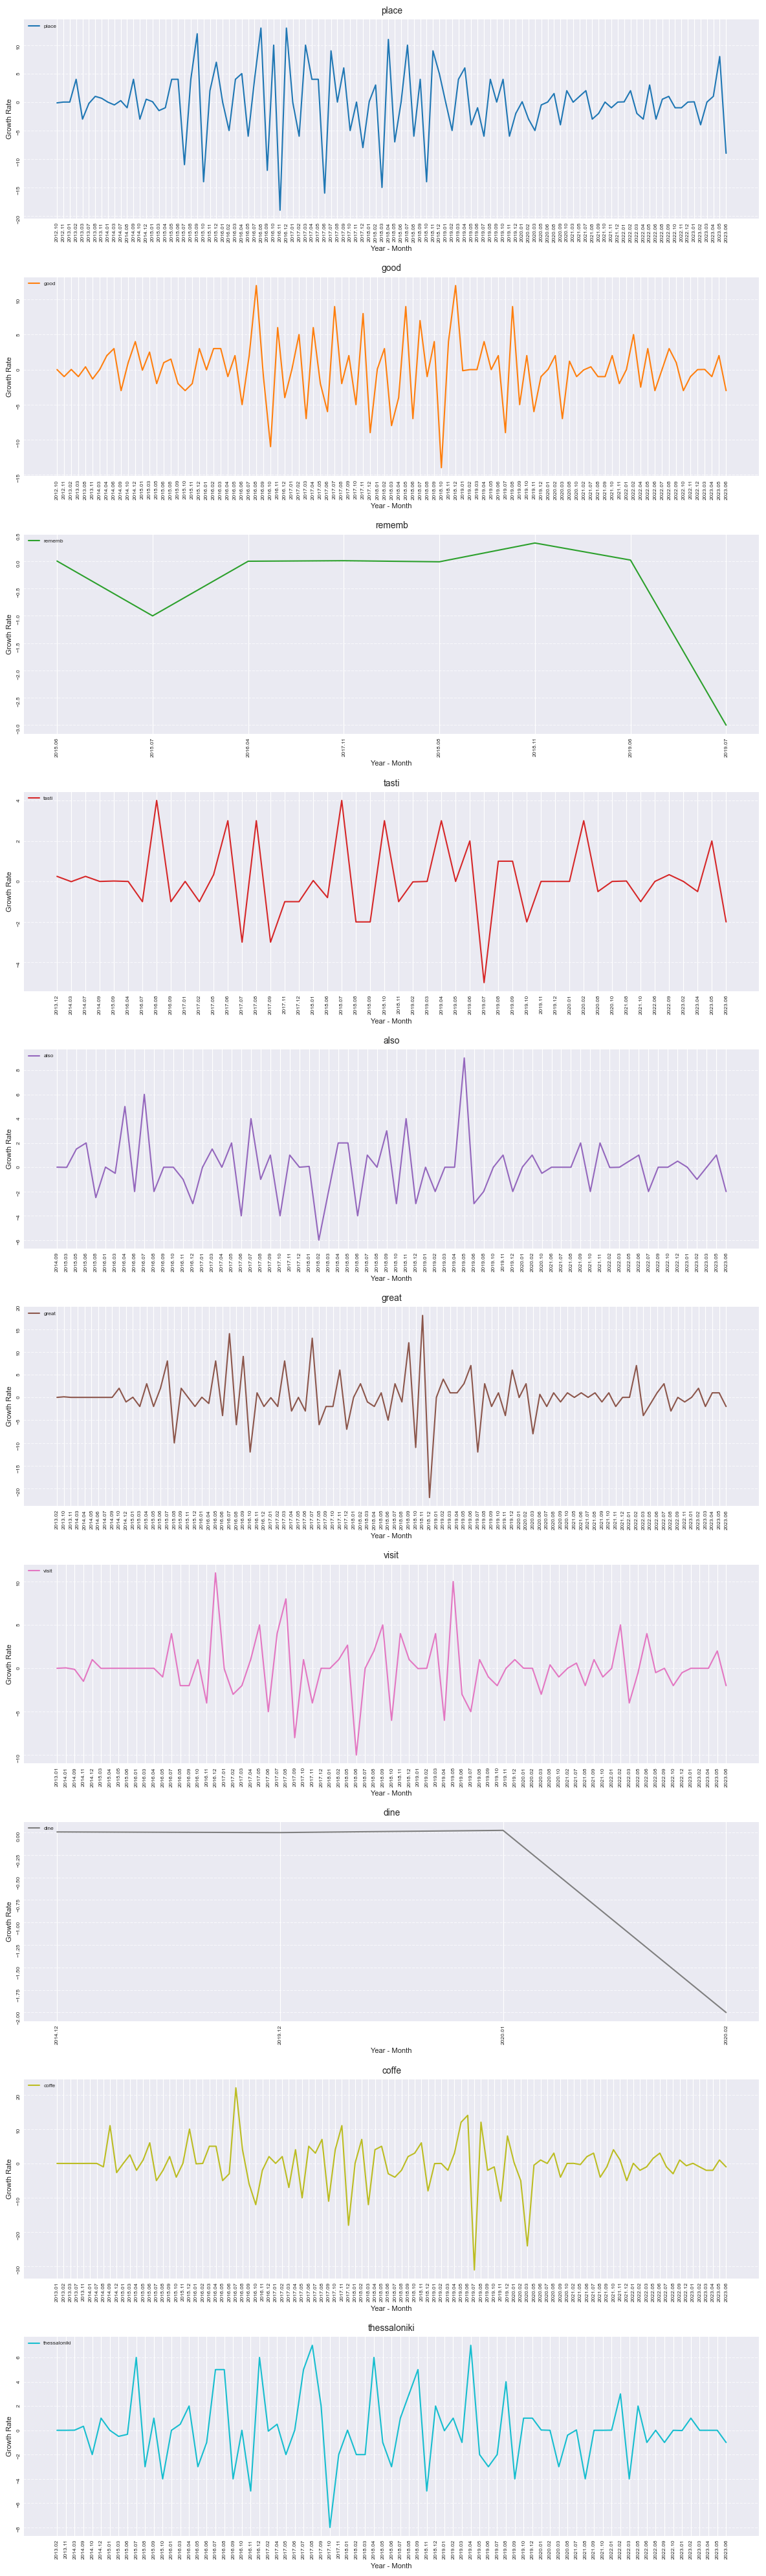

In [47]:
fig, axs = plt.subplots(10, 1, figsize=(12, 40))  
plt.title("Top 10 Shrinking Words", fontsize=16) 


for i, (word, growth_rates) in enumerate(top_10_shrinking_words):
    ax = axs[i]  # Use the current index as the subplot index
    
    years, rates = zip(*growth_rates)

    # Convert the key values to the desired format "YYYY.MM"
    formatted_years = [f"{str(year)[:4]}.{str(year)[4:].zfill(2)}" for year in years]

    ax.plot(formatted_years, rates, label=word, color=f"C{i}")
    ax.set_xlabel("Year - Month", fontsize=8)
    ax.set_ylabel("Growth Rate", fontsize=8)
    ax.set_title(word, fontsize=10)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.tick_params(labelsize=6, rotation=90)  # Rotate x-axis tick labels by 90 degrees
    ax.legend(fontsize=6, loc='upper left')

plt.tight_layout()
plt.show()

# Query 6

In [56]:
query6_df = reviews

query6_df = query6_df.drop(columns=['Business_name', 'Username', 'Visit Date', 'Review Title', 'Rating'], axis=1)


## Remove punctuation and emojis and convert to lowercase 
query6_df['text_processed'] = query6_df['Review Text']

data = query6_df.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
#data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['top', 'qualiti', 'product', 'except', 'custom', 'servic', 'tasti', 'food', 'coffe', 'also', 'good', 'one', 'favorit', 'choic']


In [51]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


In [54]:
## LDA model training----------------------------------------------------------------------------------------------

# number of topics
num_topics = 10
LDAvis_data_filepath = './plots/basic_visualizations/ldavis_prepared_' + str(num_topics)

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(LDAvis_data_filepath), exist_ok=True)
# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


## Analyzing LDA model results--------------------------------------------------------------------------------------
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./plots/basic_visualizations/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath +'.html')
LDAvis_prepared

[(0,
  '0.030*"good" + 0.026*"coffe" + 0.019*"place" + 0.014*"great" + '
  '0.013*"servic" + 0.012*"nice" + 0.010*"price" + 0.010*"staff" + '
  '0.010*"friendli" + 0.010*"realli"'),
 (1,
  '0.023*"great" + 0.015*"drink" + 0.014*"nice" + 0.014*"place" + 0.013*"go" + '
  '0.011*"music" + 0.010*"coffe" + 0.009*"good" + 0.008*"servic" + '
  '0.008*"atmospher"'),
 (2,
  '0.024*"place" + 0.023*"good" + 0.017*"coffe" + 0.015*"staff" + '
  '0.011*"thessaloniki" + 0.011*"nice" + 0.010*"drink" + 0.010*"great" + '
  '0.010*"music" + 0.009*"bar"'),
 (3,
  '0.035*"coffe" + 0.020*"nice" + 0.017*"place" + 0.016*"great" + 0.014*"one" '
  '+ 0.010*"food" + 0.010*"excel" + 0.010*"staff" + 0.010*"servic" + '
  '0.009*"good"'),
 (4,
  '0.026*"coffe" + 0.016*"bar" + 0.014*"good" + 0.013*"nice" + 0.012*"place" + '
  '0.011*"time" + 0.011*"staff" + 0.009*"friendli" + 0.008*"drink" + '
  '0.008*"tri"'),
 (5,
  '0.021*"great" + 0.016*"drink" + 0.014*"place" + 0.009*"good" + '
  '0.008*"music" + 0.008*"staff" +

c:\Users\30698\AppData\Local\Programs\Python\Python37\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.030973  0.007170       1        1  15.637885
7     -0.017259  0.022883       2        1  14.980544
3     -0.019671  0.023815       3        1  13.794284
6     -0.020866 -0.010186       4        1  13.109835
2     -0.007509  0.008764       5        1  13.039174
4     -0.037795 -0.000058       6        1   7.864040
9     -0.013461  0.018869       7        1   6.317345
5      0.084836 -0.014601       8        1   5.629736
8      0.000093 -0.095602       9        1   5.309095
1      0.062605  0.038945      10        1   4.318063, topic_info=          Term        Freq       Total Category  logprob  loglift
18       great  476.000000  476.000000  Default  30.0000  30.0000
646      music  223.000000  223.000000  Default  29.0000  29.0000
99       drink  352.000000  352.000000  Default  28.0000  28.0000
2        coffe  853.000000  853.000000  Default  27.0000  27.0000
169  atmospher  185.000000  185.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
38    sandwich    6.809732  111.038178  Topic10  -5.4682   0.3508
51       sweet    6.749407  113.690042  Topic10  -5.4771   0.3183
45        find    6.680737  105.687823  Topic10  -5.4873   0.3811
14   breakfast    6.518967  100.085118  Topic10  -5.5118   0.4111
22      realli    6.635078  225.625765  Topic10  -5.4942  -0.3841

[807 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2559      7  0.797170   abroad
2489      7  0.586766       ac
2674      1  0.689509   action
2510      7  0.586760    admit
2949      2  0.278439   aegean
...     ...       ...      ...
82       10  0.047194    would
2676      1  0.689547      yay
2677      1  0.689493      yep
1769      7  0.797195     york
2547      4  0.560449  younger

[1995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 4, 7, 3, 5, 10, 6, 9, 2])